In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
pat = pd.read_csv('../../eICU_dbmake/eicu-code/build-db/postgres/csv_files/patient.csv')
admdx = pd.read_csv('../../eICU_dbmake/eicu-code/build-db/postgres/csv_files/admissionDx.csv')
qa = pd.read_csv('../data/intermediate/patid_aki_label_offset.csv')

In [11]:
qa.columns = ['patientunitstayid', 'aki_label', 'aki_offset']
qa.set_index('patientunitstayid', inplace=True)
qa.head()

,aki_label,aki_offset
patientunitstayid,,
141284,0,NaN
141288,0,NaN
141360,0,NaN
141362,0,NaN
141415,0,NaN


In [5]:
qa[qa.aki_offset.notnull()]['aki_offset'].median()/60

57.93333333333333

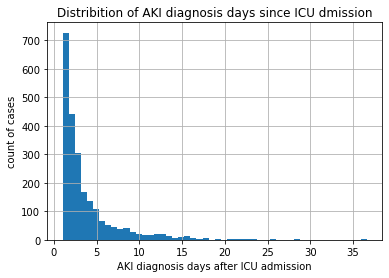

In [6]:
offset_hour = qa[qa.aki_label==1]['aki_offset']/(60*24)
offset_hour.sort_values(inplace=True)
offset_hour.hist(bins=50)
plt.ylabel('count of cases')
plt.xlabel('AKI diagnosis days after ICU admission')
plt.title('Distribition of AKI diagnosis days since ICU dmission');

(0.0, 100.0)

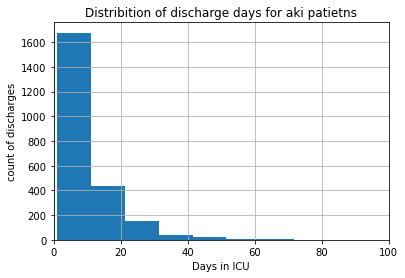

In [97]:
disch_offset_hour = pat[pat.aki_label==1]['unitdischargeoffset']/(60*24)
disch_offset_hour = disch_offset_hour#[disch_offset_hour<=40]
disch_offset_hour.sort_values(inplace=True)
disch_offset_hour.hist(bins=50)
plt.ylabel('count of discharges')
plt.xlabel('Days in ICU')
plt.title('Distribition of discharge days for aki patietns');
plt.xlim(0,100)

(0.0, 100.0)

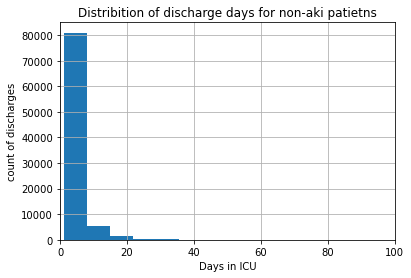

In [98]:
disch_offset_hour = pat[pat.aki_label==0]['unitdischargeoffset']/(60*24)
disch_offset_hour = disch_offset_hour#[disch_offset_hour<=40]
disch_offset_hour.sort_values(inplace=True)
disch_offset_hour.hist(bins=50)
plt.ylabel('count of discharges')
plt.xlabel('Days in ICU')
plt.title('Distribition of discharge days for non-aki patietns');
plt.xlim(0,100)

AKI diagnosis events appear to be poisson distributed.

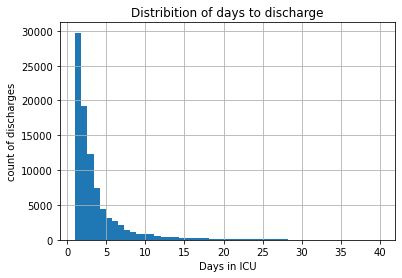

In [15]:
disch_offset_day = pat['unitdischargeoffset']/(60*24)
disch_offset_day.sort_values(inplace=True)
disch_offset_day[disch_offset_day<=40].hist(bins=50)
plt.ylabel('count of discharges')
plt.xlabel('Days in ICU')
plt.title('Distribition of days to discharge');

In [12]:
print(len(pat))
pat = pat.merge(qa, left_on = 'patientunitstayid', right_on = 'patientunitstayid')
print(len(pat))

200859
90804


In [88]:
print(pat[pat.aki_label==1]['unitdischargestatus'].value_counts()/len(pat[pat.aki_label==1]))
print(pat['unitdischargestatus'].value_counts()/len(pat))

Alive      0.784794
Expired    0.215206
Name: unitdischargestatus, dtype: float64
Alive      0.952421
Expired    0.047579
Name: unitdischargestatus, dtype: float64


aki_label
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

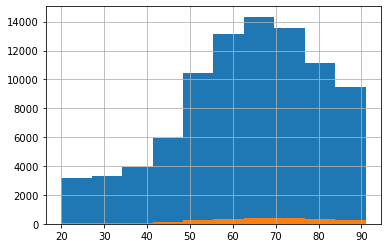

In [100]:
pat['age'] = pat['age'].astype(int)
pat.groupby('aki_label')['age'].hist()

Text(0.5, 1.0, 'cumulative distribution of age for aki positive and negative patients')

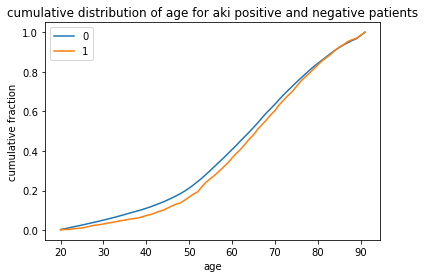

In [103]:
age_dist_grouped = pat.groupby('aki_label')['age'].value_counts()
age_dist_grouped = age_dist_grouped.unstack(level=0)
age_dist_grouped = pd.DataFrame(age_dist_grouped.values, index=age_dist_grouped.index.tolist(), \
columns=age_dist_grouped.columns.tolist())
age_dist_grouped.sort_index(inplace=True)
age_dist_grouped = age_dist_grouped/age_dist_grouped.sum(axis=0)
age_dist_cumulative = age_dist_grouped.cumsum()
age_dist_cumulative.plot()
plt.xlabel('age')
plt.ylabel('cumulative fraction')
plt.title('cumulative distribution of age for aki positive and negative patients')

In [6]:
print(len(admdx))
admdx = admdx.merge(qa, left_on = 'patientunitstayid', right_on = 'patientunitstayid')
print(len(admdx))

626858
325047


In [7]:
admdx['organ_system'] = admdx['admitdxpath'].str.split(pat="\|Organ System\|", n=1).str[1]
admdx['organ_system'].head(5).tolist()

['Cardiovascular', nan, nan, nan, nan]

In [8]:
admdx['from_OR'] = admdx['admitdxpath'].str.split(pat="O.R. within 4 hours of admission\?\|", n=1).str[1]
admdx['from_OR'].head(5).tolist()

[nan, 'Yes', nan, nan, nan]

In [9]:
admdx['from_OR'].value_counts()

No     71926
Yes    18878
Name: from_OR, dtype: int64

In [10]:
diag_summary = admdx.groupby('patientunitstayid')['organ_system'].apply(lambda x: x.str.cat(sep=' '))
print(diag_summary.value_counts())
print(diag_summary.isnull().sum())

Cardiovascular          38790
Neurologic              17144
Respiratory             14957
Gastrointestinal         9615
Trauma                   4247
Metabolic/Endocrine      3244
Musculoskeletal/Skin     1138
Genitourinary             968
Hematology                585
Transplant                116
Name: organ_system, dtype: int64
0


In [83]:
diag_summary_label = pd.concat([diag_summary, qa], axis=1, ignore_index=False)
diag_summary_label

,organ_system,aki_label,aki_offset
patientunitstayid,,,
141284,Hematology,0,NaN
141288,Cardiovascular,0,NaN
141360,Neurologic,0,NaN
141362,Gastrointestinal,0,NaN
141415,Cardiovascular,0,NaN
...,...,...,...
3353198,Neurologic,0,NaN
3353200,Cardiovascular,0,NaN
3353201,Respiratory,0,NaN


In [85]:
print(diag_summary_label[diag_summary_label.aki_label==1]['organ_system'].value_counts()/len(diag_summary_label[diag_summary_label.aki_label==1]))
print(diag_summary_label['organ_system'].value_counts()/len(diag_summary_label))

Cardiovascular          0.546821
Respiratory             0.162371
Gastrointestinal        0.108677
Neurologic              0.101804
Trauma                  0.025773
Metabolic/Endocrine     0.022337
Musculoskeletal/Skin    0.012027
Genitourinary           0.008591
Hematology              0.007302
Transplant              0.004296
Name: organ_system, dtype: float64
Cardiovascular          0.427184
Neurologic              0.188802
Respiratory             0.164717
Gastrointestinal        0.105887
Trauma                  0.046771
Metabolic/Endocrine     0.035725
Musculoskeletal/Skin    0.012532
Genitourinary           0.010660
Hematology              0.006442
Transplant              0.001277
Name: organ_system, dtype: float64


There is an enrichment of cardiovascular and respiratory system. The negative  class could be resampled to have the same distribution.

In [11]:
or_summary = admdx.groupby('patientunitstayid')['from_OR'].apply(lambda x: x.str.cat(sep=' '))
print(or_summary.value_counts())
print(or_summary.isnull().sum())

No     71926
Yes    18878
Name: from_OR, dtype: int64
0


In [87]:
or_summary_label = pd.concat([or_summary, qa], axis=1, ignore_index=False)
print(or_summary_label[or_summary_label.aki_label==1]['from_OR'].value_counts()/len(or_summary_label[or_summary_label.aki_label==1]))
print(or_summary_label['from_OR'].value_counts()/len(or_summary_label))

No     0.817869
Yes    0.182131
Name: from_OR, dtype: float64
No     0.792102
Yes    0.207898
Name: from_OR, dtype: float64


In [12]:
diag_summary_encoded = pd.get_dummies(diag_summary, prefix='organsys', prefix_sep='_', drop_first=False) 
diag_summary_encoded.drop('organsys_Transplant', axis=1, inplace=True)
diag_summary_encoded.head()

,organsys_Cardiovascular,organsys_Gastrointestinal,organsys_Genitourinary,organsys_Hematology,organsys_Metabolic/Endocrine,organsys_Musculoskeletal/Skin,organsys_Neurologic,organsys_Respiratory,organsys_Trauma
patientunitstayid,,,,,,,,,
141284,0,0,0,1,0,0,0,0,0
141288,1,0,0,0,0,0,0,0,0
141360,0,0,0,0,0,0,1,0,0
141362,0,1,0,0,0,0,0,0,0
141415,1,0,0,0,0,0,0,0,0


In [13]:
or_summary_encoded = pd.get_dummies(or_summary, prefix='from_or', prefix_sep='_', drop_first=True) 
or_summary_encoded.head()

,from_or_Yes
patientunitstayid,
141284,0
141288,0
141360,0
141362,1
141415,0


In [14]:
print("Positive label gender summary")
print(pat[pat.aki_label==1]['gender'].value_counts())
print(pat[pat.aki_label==1]['gender'].isnull().sum())

print("Positive label ethnicity summary")
print(pat[pat.aki_label==1]['ethnicity'].value_counts())
print(pat[pat.aki_label==1]['ethnicity'].isnull().sum())

print("Positive label unittype summary")
print(pat[pat.aki_label==1]['unittype'].value_counts())
print(pat[pat.aki_label==1]['unittype'].isnull().sum())

print("Positive label unitdischargestatus summary")
print(pat[pat.aki_label==1]['unitdischargestatus'].value_counts())
print(pat[pat.aki_label==1]['unitdischargestatus'].isnull().sum())

#print(pat.gender.value_counts())
#print(pat.ethnicity.value_counts())
#print(pat.unittype.value_counts())
#print(pat.unitdischargestatus.value_counts())

Positive label gender summary
Male      1308
Female    1020
Name: gender, dtype: int64
0
Positive label ethnicity summary
Caucasian           1778
African American     245
Hispanic             135
Other/Unknown         86
Asian                 40
Native American       23
Name: ethnicity, dtype: int64
21
Positive label unittype summary
Med-Surg ICU    1298
MICU             204
Cardiac ICU      198
CCU-CTICU        192
CSICU            124
SICU             121
Neuro ICU        107
CTICU             84
Name: unittype, dtype: int64
0
Positive label unitdischargestatus summary
Alive      1826
Expired     501
Name: unitdischargestatus, dtype: int64
1


* drop the rows with null gender values, negative labels
* assign missing ethnicity values to Other/Unknown
* assign null unitdischargestatus to alive

In [15]:
pat.columns

Index(['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age',
       'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx',
       'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset',
       'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid', 'aki_label', 'aki_offset'],
      dtype='object')

In [16]:
pat[['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'unittype', 'unitvisitnumber', 'unitdischargeoffset', \
     'unitdischargestatus']].isnull().sum()

patientunitstayid               0
patienthealthsystemstayid       0
gender                         17
age                             0
ethnicity                    1063
unittype                        0
unitvisitnumber                 0
unitdischargeoffset             0
unitdischargestatus             2
dtype: int64

In [17]:
# need to convert age comparisons to numeric values
pat.loc[pat.age == '> 89', 'age'] = 91
pat.age.mode()

0    91
dtype: object

In [18]:
pat.gender.value_counts()

Male       48747
Female     42028
Unknown        8
Other          4
Name: gender, dtype: int64

In [19]:
pat = pat.loc[(pat.gender=='Male') | (pat.gender=='Female')]
pat.loc[pat.ethnicity.isnull(), 'ethnicity'] = 'Other/Unknown'
pat.loc[pat.unitdischargestatus.isnull(), 'unitdischargestatus'] = 'Alive'

In [20]:
pat[['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'unittype', 'unitvisitnumber', 'unitdischargeoffset', \
     'unitdischargestatus']].isnull().sum()

patientunitstayid            0
patienthealthsystemstayid    0
gender                       0
age                          0
ethnicity                    0
unittype                     0
unitvisitnumber              0
unitdischargeoffset          0
unitdischargestatus          0
dtype: int64

In [68]:
print(pat[pat.aki_label==1]['unittype'].value_counts()/len(pat[pat.aki_label==1]))
print(pat['unittype'].value_counts()/len(pat))

Med-Surg ICU    0.557560
MICU            0.087629
Cardiac ICU     0.085052
CCU-CTICU       0.082474
CSICU           0.053265
SICU            0.051976
Neuro ICU       0.045962
CTICU           0.036082
Name: unittype, dtype: float64
Med-Surg ICU    0.524517
Neuro ICU       0.088295
MICU            0.085850
CCU-CTICU       0.085310
Cardiac ICU     0.071000
SICU            0.070890
CSICU           0.039681
CTICU           0.034459
Name: unittype, dtype: float64


In [67]:
print(pat[pat.aki_label==1]['gender'].value_counts()/len(pat[pat.aki_label==1]))
print(pat['gender'].value_counts()/len(pat))

Male      0.561856
Female    0.438144
Name: gender, dtype: float64
Male      0.537009
Female    0.462991
Name: gender, dtype: float64


In [69]:
print(pat[pat.aki_label==1]['ethnicity'].value_counts()/len(pat[pat.aki_label==1]))
print(pat['ethnicity'].value_counts()/len(pat))

Caucasian           0.763746
African American    0.105241
Hispanic            0.057990
Other/Unknown       0.045962
Asian               0.017182
Native American     0.009880
Name: ethnicity, dtype: float64
Caucasian           0.776161
African American    0.103905
Other/Unknown       0.060028
Hispanic            0.035946
Asian               0.017758
Native American     0.006202
Name: ethnicity, dtype: float64


Most fractions for demographic features of positive AKI labels are similar to the general ICU population fractions.
Maybe slight enrichment in male gender and hispanic ethnicity.

In [21]:
pat.set_index('patientunitstayid', inplace=True)
pat.head()

,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,hospitaladmitoffset,...,unitstaytype,admissionweight,dischargeweight,unitdischargetime24,unitdischargeoffset,unitdischargelocation,unitdischargestatus,uniquepid,aki_label,aki_offset
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141284,129017,Male,63,Caucasian,73,92,Anemia,188.0,23:10:00,-15,...,admit,NaN,88.5,10:01:00,2076,Floor,Alive,002-72371,0,NaN
141288,129020,Female,61,Caucasian,67,109,"Sepsis, pulmonary",162.6,17:32:00,-171,...,admit,NaN,92.2,23:34:00,1631,Floor,Alive,002-67735,0,NaN
141360,129080,Male,48,Caucasian,73,102,"CVA, cerebrovascular accident/stroke",175.3,18:39:00,-30,...,admit,NaN,92.3,22:58:00,3109,Floor,Alive,002-34250,0,NaN
141362,129082,Male,65,Caucasian,73,93,"Cholecystectomy/cholangitis, surgery for (gall...",172.7,21:03:00,-1505,...,admit,NaN,65.1,02:06:00,3118,Floor,Alive,002-66659,0,NaN
141415,129126,Male,30,Caucasian,66,90,"Thrombosis, vascular (deep vein)",193.0,17:04:00,-347,...,admit,87.1,86.7,00:41:00,4430,Floor,Alive,002-42357,0,NaN


In [22]:
cat_columns = ['gender', 'ethnicity', 'unittype', 'unitdischargestatus']
pat_cat_encoded = pd.get_dummies(pat[cat_columns], prefix_sep='_', drop_first=False)
pat_cat_encoded.head()

,gender_Female,gender_Male,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,unittype_CCU-CTICU,unittype_CSICU,unittype_CTICU,unittype_Cardiac ICU,unittype_MICU,unittype_Med-Surg ICU,unittype_Neuro ICU,unittype_SICU,unitdischargestatus_Alive,unitdischargestatus_Expired
patientunitstayid,,,,,,,,,,,,,,,,,,
141284,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
141288,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
141360,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
141362,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
141415,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0


In [23]:
cols_to_drop = ['gender_Male', 'ethnicity_Native American', 'unittype_CTICU', 'unitdischargestatus_Expired']
pat_cat_encoded.drop(columns=cols_to_drop, inplace=True)
pat_cat_encoded.columns.tolist()

['gender_Female',
 'ethnicity_African American',
 'ethnicity_Asian',
 'ethnicity_Caucasian',
 'ethnicity_Hispanic',
 'ethnicity_Other/Unknown',
 'unittype_CCU-CTICU',
 'unittype_CSICU',
 'unittype_Cardiac ICU',
 'unittype_MICU',
 'unittype_Med-Surg ICU',
 'unittype_Neuro ICU',
 'unittype_SICU',
 'unitdischargestatus_Alive']

In [24]:
# keep track of droped columns for interpretation
droped_cols = ['organsys_Transplant', 'ethnicity_Native American', 'unittype_CTICU']

In [25]:
# put together all relevant encoded values
# qa
# diag_summary_encoded
# or_summary_encoded
# pat_cat_encoded
# pat[['patientunitstayid', 'age', 'unitvisitnumber', 'unitdischargeoffset']]
#pat.age = pat.age.astype(int) # age is stored as string, convert to int
combined_df = pd.concat([qa, diag_summary_encoded, or_summary_encoded, pat_cat_encoded, \
                         pat[['age', 'patienthealthsystemstayid', 'unitvisitnumber', 'unitdischargeoffset']]], \
                        axis=1, ignore_index=False)
print(len(combined_df))
print(combined_df.isnull().sum())

90804
aki_label                            0
aki_offset                       88476
organsys_Cardiovascular              0
organsys_Gastrointestinal            0
organsys_Genitourinary               0
organsys_Hematology                  0
organsys_Metabolic/Endocrine         0
organsys_Musculoskeletal/Skin        0
organsys_Neurologic                  0
organsys_Respiratory                 0
organsys_Trauma                      0
from_or_Yes                          0
gender_Female                       29
ethnicity_African American          29
ethnicity_Asian                     29
ethnicity_Caucasian                 29
ethnicity_Hispanic                  29
ethnicity_Other/Unknown             29
unittype_CCU-CTICU                  29
unittype_CSICU                      29
unittype_Cardiac ICU                29
unittype_MICU                       29
unittype_Med-Surg ICU               29
unittype_Neuro ICU                  29
unittype_SICU                       29
unitdischargestatus

In [26]:
combined_df[combined_df.aki_label==1].isnull().sum()

aki_label                        0
aki_offset                       0
organsys_Cardiovascular          0
organsys_Gastrointestinal        0
organsys_Genitourinary           0
organsys_Hematology              0
organsys_Metabolic/Endocrine     0
organsys_Musculoskeletal/Skin    0
organsys_Neurologic              0
organsys_Respiratory             0
organsys_Trauma                  0
from_or_Yes                      0
gender_Female                    0
ethnicity_African American       0
ethnicity_Asian                  0
ethnicity_Caucasian              0
ethnicity_Hispanic               0
ethnicity_Other/Unknown          0
unittype_CCU-CTICU               0
unittype_CSICU                   0
unittype_Cardiac ICU             0
unittype_MICU                    0
unittype_Med-Surg ICU            0
unittype_Neuro ICU               0
unittype_SICU                    0
unitdischargestatus_Alive        0
age                              0
patienthealthsystemstayid        0
unitvisitnumber     

In [30]:
combined_df.dropna(inplace=True)
combined_df.isnull().sum()

aki_label                        0
aki_offset                       0
organsys_Cardiovascular          0
organsys_Gastrointestinal        0
organsys_Genitourinary           0
organsys_Hematology              0
organsys_Metabolic/Endocrine     0
organsys_Musculoskeletal/Skin    0
organsys_Neurologic              0
organsys_Respiratory             0
organsys_Trauma                  0
from_or_Yes                      0
gender_Female                    0
ethnicity_African American       0
ethnicity_Asian                  0
ethnicity_Caucasian              0
ethnicity_Hispanic               0
ethnicity_Other/Unknown          0
unittype_CCU-CTICU               0
unittype_CSICU                   0
unittype_Cardiac ICU             0
unittype_MICU                    0
unittype_Med-Surg ICU            0
unittype_Neuro ICU               0
unittype_SICU                    0
unitdischargestatus_Alive        0
age                              0
patienthealthsystemstayid        0
unitvisitnumber     

In [31]:
combined_df.to_csv('../data/intermediate/pat_admit_diag_cleaned.csv')

In [32]:
# keep track of index columns
index_cols = ['patientunitstayid'] # currently used as index

# keep track of cols important for stratification
strat_cols = ['unitvisitnumber', 'patienthealthsystemstayid', 'aki_label', 'unitdischargestatus_Alive']

# keep track of columns important for time tracking
time_cols = ['aki_offset', 'unitdischargeoffset']

# keep track of numerical columns
num_cols = ['age']

# keep track of categorical columns
cat_cols = ['organsys_Cardiovascular', 'organsys_Gastrointestinal',
       'organsys_Genitourinary', 'organsys_Hematology',
       'organsys_Metabolic/Endocrine', 'organsys_Musculoskeletal/Skin',
       'organsys_Neurologic', 'organsys_Respiratory', 'organsys_Trauma',
       'from_or_Yes', 'gender_Female', 'ethnicity_African American',
       'ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic',
       'ethnicity_Other/Unknown', 'unittype_CCU-CTICU', 'unittype_CSICU',
       'unittype_Cardiac ICU', 'unittype_MICU', 'unittype_Med-Surg ICU',
       'unittype_Neuro ICU', 'unittype_SICU', 'unitdischargestatus_Alive']

# keep track of target variables
target_cols = ['aki_label', 'unitdischargestatus_Alive']

In [33]:
combined_df.columns

Index(['aki_label', 'aki_offset', 'organsys_Cardiovascular',
       'organsys_Gastrointestinal', 'organsys_Genitourinary',
       'organsys_Hematology', 'organsys_Metabolic/Endocrine',
       'organsys_Musculoskeletal/Skin', 'organsys_Neurologic',
       'organsys_Respiratory', 'organsys_Trauma', 'from_or_Yes',
       'gender_Female', 'ethnicity_African American', 'ethnicity_Asian',
       'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Other/Unknown',
       'unittype_CCU-CTICU', 'unittype_CSICU', 'unittype_Cardiac ICU',
       'unittype_MICU', 'unittype_Med-Surg ICU', 'unittype_Neuro ICU',
       'unittype_SICU', 'unitdischargestatus_Alive', 'age',
       'patienthealthsystemstayid', 'unitvisitnumber', 'unitdischargeoffset'],
      dtype='object')

In [76]:
combined_df = pd.read_csv('../data/intermediate/pat_admit_diag_cleaned.csv')
combined_df.set_index('patientunitstayid', inplace=True)
combined_df.head()

,aki_label,aki_offset,organsys_Cardiovascular,organsys_Gastrointestinal,organsys_Genitourinary,organsys_Hematology,organsys_Metabolic/Endocrine,organsys_Musculoskeletal/Skin,organsys_Neurologic,organsys_Respiratory,...,unittype_Cardiac ICU,unittype_MICU,unittype_Med-Surg ICU,unittype_Neuro ICU,unittype_SICU,unitdischargestatus_Alive,age,patienthealthsystemstayid,unitvisitnumber,unitdischargeoffset
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
142388,1,1757.0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,1.0,67,129864.0,1.0,8407.0
142974,1,2241.0,0,0,0,0,0,0,1,0,...,0.0,0.0,1.0,0.0,0.0,1.0,54,130310.0,1.0,3906.0
143466,1,7083.0,1,0,0,0,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,1.0,60,130702.0,1.0,13963.0
143518,1,4468.0,1,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,66,130741.0,1.0,6726.0
144173,1,1778.0,0,0,1,0,0,0,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,40,131256.0,1.0,6165.0


In [77]:
lab = pd.read_csv('../data/intermediate/lab_summary_prior.csv', header=None)
lab.columns = ['patientunitstayid', 'labname', 'min_result', 'max_result', 'delta_result']
lab.set_index(['patientunitstayid', 'labname'], inplace=True)
lab = lab.unstack(level=1)
lab.columns = lab.columns.map('_'.join)
lab.head()

,min_result_BUN,min_result_FiO2,min_result_HCO3,min_result_Hct,min_result_Hgb,min_result_MCH,min_result_MCHC,min_result_MCV,min_result_MPV,min_result_RBC,...,delta_result_chloride,delta_result_creatinine,delta_result_glucose,delta_result_magnesium,delta_result_pH,delta_result_paCO2,delta_result_paO2,delta_result_platelets x 1000,delta_result_potassium,delta_result_sodium
patientunitstayid,,,,,,,,,,,,,,,,,,,,,
141284,20.0,NaN,NaN,27.1,8.8,26.3,32.7,80.2,NaN,3.54,...,0.0,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
141288,17.0,100.0,24.0,35.4,11.8,31.8,32.5,97.8,NaN,3.62,...,0.0,0.00,0.0,NaN,0.0,0.0,0.0,31.0,0.0,0.0
141360,13.0,NaN,NaN,48.9,16.6,29.9,33.9,88.1,NaN,5.55,...,0.0,0.00,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
141362,16.0,NaN,NaN,36.6,11.8,29.8,32.2,92.2,NaN,3.87,...,4.0,0.21,20.0,0.5,NaN,NaN,NaN,13.0,0.8,2.0
141415,13.0,NaN,NaN,37.4,12.2,32.0,32.1,96.8,NaN,3.76,...,3.0,0.29,51.0,NaN,NaN,NaN,NaN,58.0,0.4,2.0


In [78]:
combined_df = combined_df.merge(lab, left_index=True, right_index=True)
missing_vals = combined_df[combined_df.aki_label==1].isnull().sum()
missing_vals_fract = missing_vals/len(combined_df[combined_df.aki_label==1])
len(missing_vals_fract[missing_vals_fract>0.2])

27

In [81]:
lab_cols_todrop = missing_vals_fract[missing_vals_fract>0.1].index.tolist()
lab_cols_todrop

['min_result_FiO2',
 'min_result_HCO3',
 'min_result_MCH',
 'min_result_MPV',
 'min_result_RDW',
 'min_result_anion gap',
 'min_result_bedside glucose',
 'min_result_magnesium',
 'min_result_pH',
 'min_result_paCO2',
 'min_result_paO2',
 'max_result_FiO2',
 'max_result_HCO3',
 'max_result_MCH',
 'max_result_MPV',
 'max_result_RDW',
 'max_result_anion gap',
 'max_result_bedside glucose',
 'max_result_magnesium',
 'max_result_pH',
 'max_result_paCO2',
 'max_result_paO2',
 'delta_result_FiO2',
 'delta_result_HCO3',
 'delta_result_MCH',
 'delta_result_MPV',
 'delta_result_RDW',
 'delta_result_anion gap',
 'delta_result_bedside glucose',
 'delta_result_magnesium',
 'delta_result_pH',
 'delta_result_paCO2',
 'delta_result_paO2']

In [234]:
combined_df_filtered = combined_df.drop(columns = lab_cols_todrop)

In [247]:
row_null_sum = combined_df_filtered.loc[combined_df['aki_label']==1].isnull().sum(axis=1).sort_values(ascending=True)
print(len(row_null_sum))
len(row_null_sum[row_null_sum<10])

2307


2116

In [248]:
combined_df_filtered_dr = combined_df_filtered[combined_df_filtered.isnull().sum(axis=1)<10]
print(len(combined_df_filtered_dr[combined_df_filtered_dr['aki_label']==1]))
print(len(combined_df_filtered_dr[combined_df_filtered_dr['aki_label']==0]))

2116
76196


In [249]:
combined_df_filtered_dr.isnull().sum()

aki_label                            0
aki_offset                       76196
organsys_Cardiovascular              0
organsys_Gastrointestinal            0
organsys_Genitourinary               0
                                 ...  
delta_result_creatinine            132
delta_result_glucose               444
delta_result_platelets x 1000      735
delta_result_potassium              72
delta_result_sodium                  5
Length: 68, dtype: int64

In [254]:
# Note I will impute missing values after splitting into train test
# strategies median, or sklearn Multivariate feature imputation

# keep track of new numerical features
num_cols += ['min_result_BUN', 'min_result_Hct',
       'min_result_Hgb', 'min_result_RBC', 'min_result_WBC x 1000',
       'min_result_bicarbonate', 'min_result_calcium', 'min_result_chloride',
       'min_result_creatinine', 'min_result_glucose',
       'min_result_platelets x 1000', 'min_result_potassium',
       'min_result_sodium', 'max_result_BUN', 'max_result_Hct',
       'max_result_Hgb', 'max_result_RBC', 'max_result_WBC x 1000',
       'max_result_bicarbonate', 'max_result_calcium', 'max_result_chloride',
       'max_result_creatinine', 'max_result_glucose',
       'max_result_platelets x 1000', 'max_result_potassium',
       'max_result_sodium', 'delta_result_BUN', 'delta_result_Hct',
       'delta_result_Hgb', 'delta_result_RBC', 'delta_result_WBC x 1000',
       'delta_result_bicarbonate', 'delta_result_calcium',
       'delta_result_chloride', 'delta_result_creatinine',
       'delta_result_glucose', 'delta_result_platelets x 1000',
       'delta_result_potassium', 'delta_result_sodium']

In [251]:
combined_df_filtered_dr.columns

Index(['aki_label', 'aki_offset', 'organsys_Cardiovascular',
       'organsys_Gastrointestinal', 'organsys_Genitourinary',
       'organsys_Hematology', 'organsys_Metabolic/Endocrine',
       'organsys_Musculoskeletal/Skin', 'organsys_Neurologic',
       'organsys_Respiratory', 'organsys_Trauma', 'from_or_Yes',
       'gender_Female', 'ethnicity_African American', 'ethnicity_Asian',
       'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Other/Unknown',
       'unittype_CCU-CTICU', 'unittype_CSICU', 'unittype_Cardiac ICU',
       'unittype_MICU', 'unittype_Med-Surg ICU', 'unittype_Neuro ICU',
       'unittype_SICU', 'unitdischargestatus_Alive', 'age', 'unitvisitnumber',
       'unitdischargeoffset', 'min_result_BUN', 'min_result_Hct',
       'min_result_Hgb', 'min_result_RBC', 'min_result_WBC x 1000',
       'min_result_bicarbonate', 'min_result_calcium', 'min_result_chloride',
       'min_result_creatinine', 'min_result_glucose',
       'min_result_platelets x 1000', 'min_resul

In [257]:
vitals = pd.read_csv('../data/intermediate/vitalperiodic_summary.csv', header=None)
vitals.columns = ['patientunitstayid','min_sao2', 'max_sao2', 'mean_sao2', 'min_heartrate', 'max_heartrate', \
                  'mean_heartrate', 'min_respiration', 'max_respiration', 'mean_respiration']
vitals.set_index('patientunitstayid', inplace=True)
vitals.head()

,min_sao2,max_sao2,mean_sao2,min_heartrate,max_heartrate,mean_heartrate,min_respiration,max_respiration,mean_respiration
patientunitstayid,,,,,,,,,
141284,92.0,100.0,96.073529,70.0,106.0,84.752613,10.0,36.0,21.254355
141288,90.0,100.0,95.219512,80.0,106.0,91.857143,11.0,46.0,21.972125
141360,96.0,100.0,98.602230,76.0,120.0,89.808118,11.0,36.0,17.656827
141362,80.0,99.0,93.338129,92.0,120.0,103.592982,11.0,42.0,24.518182
141415,97.0,100.0,98.353488,61.0,99.0,72.034722,8.0,57.0,15.880000


In [260]:
combined_df_filtered_dr_vit = combined_df_filtered_dr.merge(vitals, left_index=True, right_index=True)
row_null_sum = combined_df_filtered_dr_vit.loc[combined_df_filtered_dr_vit['aki_label']==1][vitals.columns].isnull().sum().sort_values(ascending=True)
row_null_sum

min_heartrate         0
max_heartrate         0
mean_heartrate        0
min_sao2             10
max_sao2             10
mean_sao2            10
min_respiration     140
max_respiration     140
mean_respiration    140
dtype: int64

In [261]:
row_null_sum = combined_df_filtered_dr_vit.loc[combined_df_filtered_dr_vit['aki_label']==0][vitals.columns].isnull().sum().sort_values(ascending=True)
row_null_sum

min_heartrate        162
max_heartrate        162
mean_heartrate       162
min_sao2             733
max_sao2             733
mean_sao2            733
min_respiration     5388
max_respiration     5388
mean_respiration    5388
dtype: int64

In [264]:
# respiration columns will be droped, for the rest drop the rows that are null
combined_df_filtered_dr_vit.drop(columns=['min_respiration', 'max_respiration', 'mean_respiration'])
combined_df_filtered_dr_vit_final = combined_df_filtered_dr_vit[combined_df_filtered_dr_vit[['min_heartrate', 'max_heartrate', \
                                                                                     'mean_heartrate', 'min_sao2', 'max_sao2', \
                                                                                     'mean_sao2']].isnull().sum(axis=1)==0]
print(combined_df_filtered_dr_vit_final.aki_label.sum())
print(len(combined_df_filtered_dr_vit_final))

2099
76624


In [266]:
combined_df_filtered_dr_vit_final.to_csv('../data/final/vitalperiodic_summary.csv')

In [104]:
pat.columns


Index(['patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'hospitalid',
       'wardid', 'apacheadmissiondx', 'admissionheight', 'hospitaladmittime24',
       'hospitaladmitoffset', 'hospitaladmitsource', 'hospitaldischargeyear',
       'hospitaldischargetime24', 'hospitaldischargeoffset',
       'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype',
       'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype',
       'admissionweight', 'dischargeweight', 'unitdischargetime24',
       'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus',
       'uniquepid', 'aki_label', 'aki_offset'],
      dtype='object')

In [112]:
from sklearn.model_selection import train_test_split
pat_train, pat_test = train_test_split(pat, test_size=0.2, stratify=pat[['gender', 'aki_label', 'ethnicity']])
pat_train.size

2178600

In [108]:
pat_test.size

544650

In [111]:
print(pat_train.gender.value_counts()/len(pat_train))
print(pat_test.gender.value_counts()/len(pat_test))

Male      0.537001
Female    0.462999
Name: gender, dtype: float64
Male      0.537042
Female    0.462958
Name: gender, dtype: float64
